# Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive/SIAP/dataset/clean

/content/drive/MyDrive/SIAP/dataset/clean


In [ ]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

# Import dataset

In [5]:
df = pd.read_csv('train_clean_removed_emoticons.csv')
corpus = df["Review Text"].to_list()

# Tokenize Sentences and Clean

In [6]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  


# Convert to list
data = df["Review Text"].values.tolist()
data_words = list(sent_to_words(data))

# print(data_words[:1])

# Build the Bigram, Trigram Models and Lemmatize

In [7]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [8]:
# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

# Build the Topic Model

In [9]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.028*"sleeve" + 0.027*"sweater" + 0.022*"give" + 0.022*"fall" + '
  '0.021*"price" + 0.018*"color" + 0.017*"light" + 0.015*"shape" + '
  '0.015*"piece" + 0.015*"show"'),
 (1,
  '0.031*"look" + 0.028*"top" + 0.027*"short" + 0.020*"size" + 0.020*"fit" + '
  '0.019*"waist" + 0.016*"small" + 0.016*"really" + 0.015*"little" + '
  '0.014*"skirt"'),
 (2,
  '0.111*"dress" + 0.042*"fabric" + 0.040*"flattering" + 0.032*"perfect" + '
  '0.031*"much" + 0.029*"feel" + 0.029*"look" + 0.025*"back" + 0.021*"black" + '
  '0.020*"store"'),
 (3,
  '0.050*"wear" + 0.039*"love" + 0.036*"size" + 0.035*"fit" + 0.030*"great" + '
  '0.026*"color" + 0.022*"order" + 0.019*"buy" + 0.017*"top" + 0.016*"well"')]


# What is the Dominant topic and its percentage contribution in each document

In [10]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.7064,"dress, fabric, flattering, perfect, much, feel...","[foot, order, small, petite, issue, however, g..."
1,1,3.0,0.9168,"wear, love, size, fit, great, color, order, bu...","[pant, great, tall, actually, hair, long, comp..."
2,2,3.0,0.8607,"wear, love, size, fit, great, color, order, bu...","[buy, usually, wear, small, size, leave, neutr..."
3,3,3.0,0.6287,"wear, love, size, fit, great, color, order, bu...","[loved, shirt, pretty, big, normally, med, due..."
4,4,2.0,0.8258,"dress, fabric, flattering, perfect, much, feel...","[love, dress, dress, store, sale, girl, put, f..."
5,5,3.0,0.8512,"wear, love, size, fit, great, color, order, bu...","[purchase, motif, love, pull, pant, hook, last..."
6,6,2.0,0.7062,"dress, fabric, flattering, perfect, much, feel...","[adorable, fabric, lighter, imagine, flatterin..."
7,7,3.0,0.5497,"wear, love, size, fit, great, color, order, bu...","[love, love, color, style, work, immediately, ..."
8,8,1.0,0.8610,"look, top, short, size, fit, waist, small, rea...","[usually, size, retailer, button, bottom, exci..."
9,9,0.0,0.5836,"sleeve, sweater, give, fall, price, color, lig...","[picture, online, show, intricate, knitting, l..."


# The most representative sentence for each topic


In [11]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.8903,"sleeve, sweater, give, fall, price, color, light, shape, piece, show","[invert, obvious, first, shrunk, harder, ingnore]"
1,1.0,0.9146,"look, top, short, size, fit, waist, small, really, little, skirt","[bra, push, padding, small, size, little, overkill, unnecessary]"
2,2.0,0.9372,"dress, fabric, flattering, perfect, much, feel, look, back, black, store","[look, dress, twice, online, tried, store, floor, beautiful, flattering, much, fun]"
3,3.0,0.9607,"wear, love, size, fit, great, color, order, buy, top, well","[grab, pair, pj, pant, sale, glad, material, soft, lightweight, ideal, summer, fit, loose, true,..."


# Frequency Distribution of Word Counts in Documents

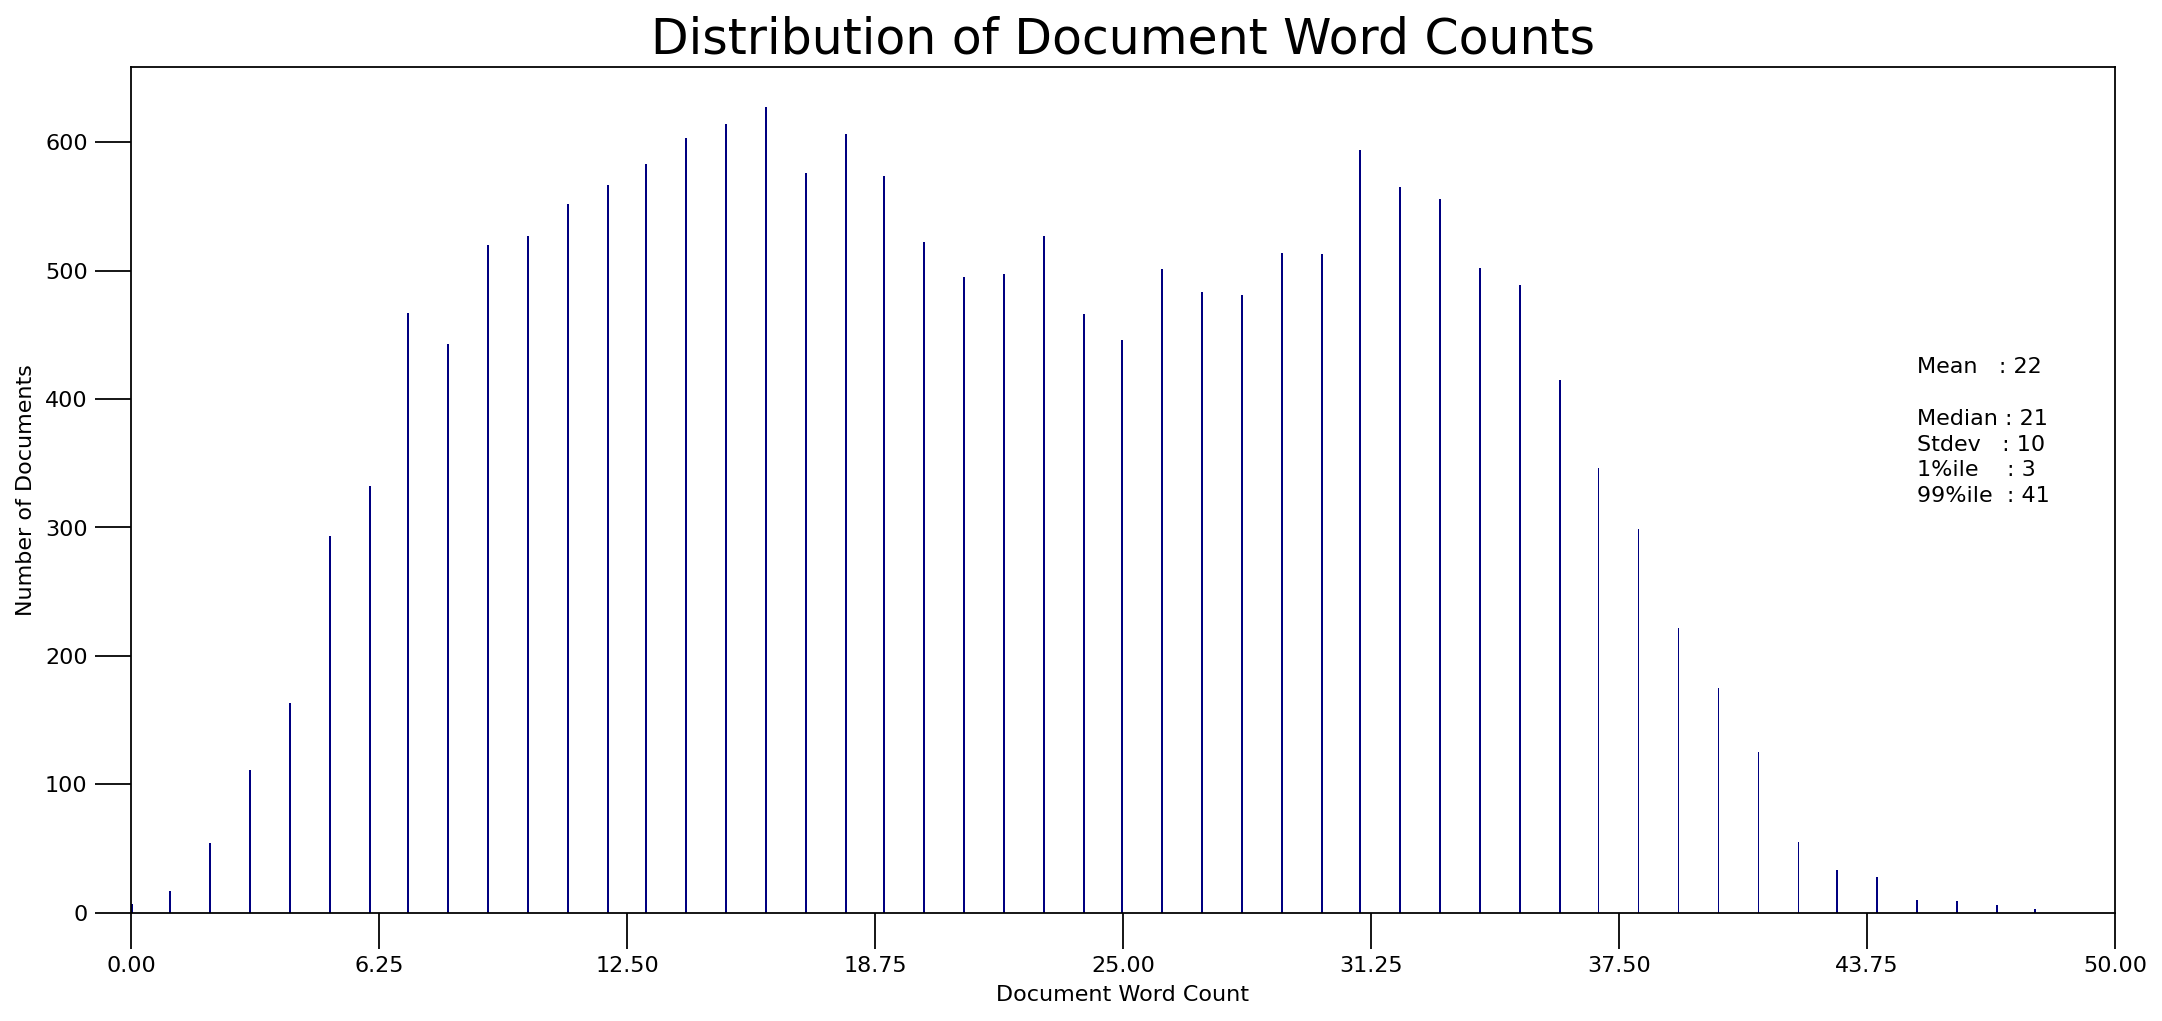

In [25]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(45, 420, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(45,  380, "Median : " + str(round(np.median(doc_lens))))
plt.text(45,  360, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(45,  340, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(45,  320, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 50), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,50,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

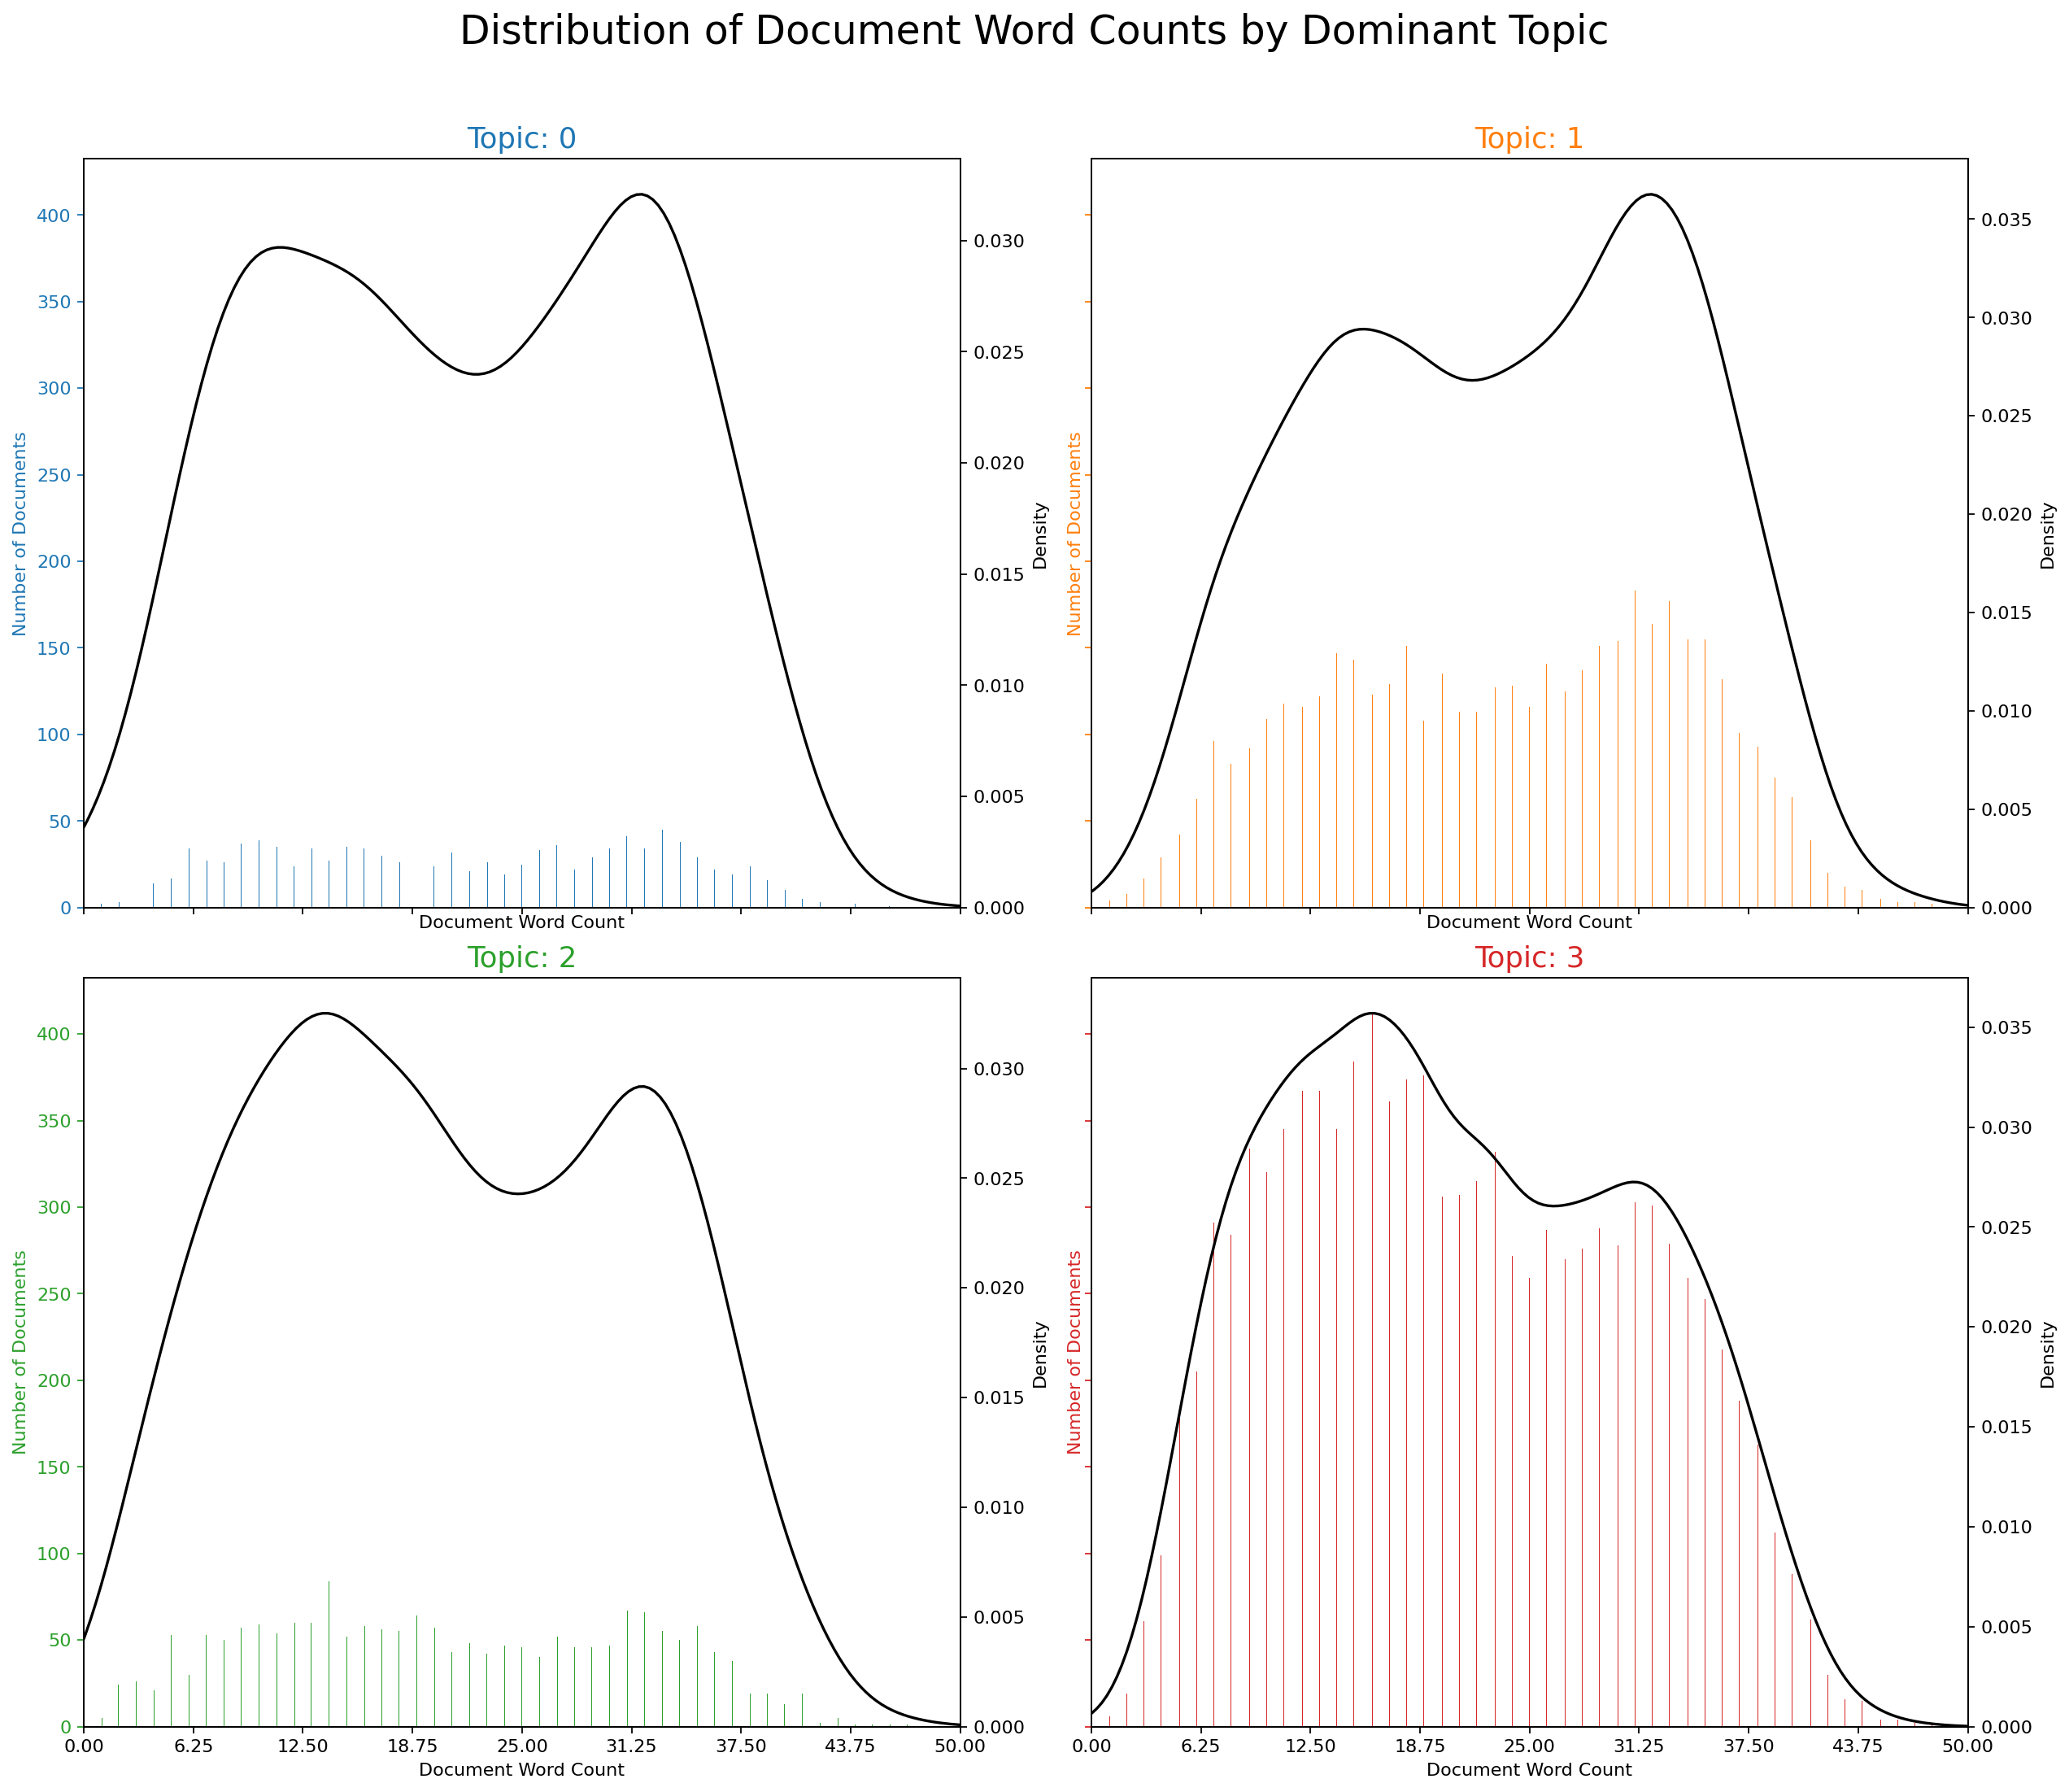

In [27]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 50), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,50,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

# Word Clouds of Top N Keywords in Each Topic

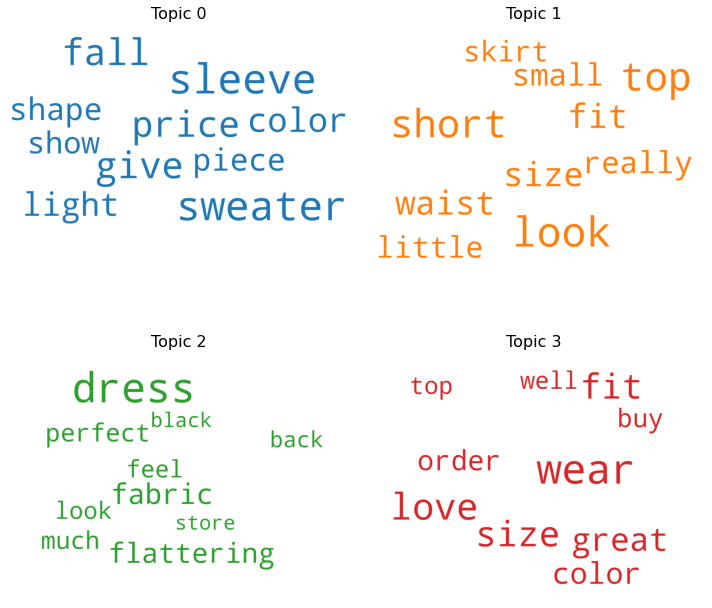

In [28]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

# Word Counts of Topic Keywords

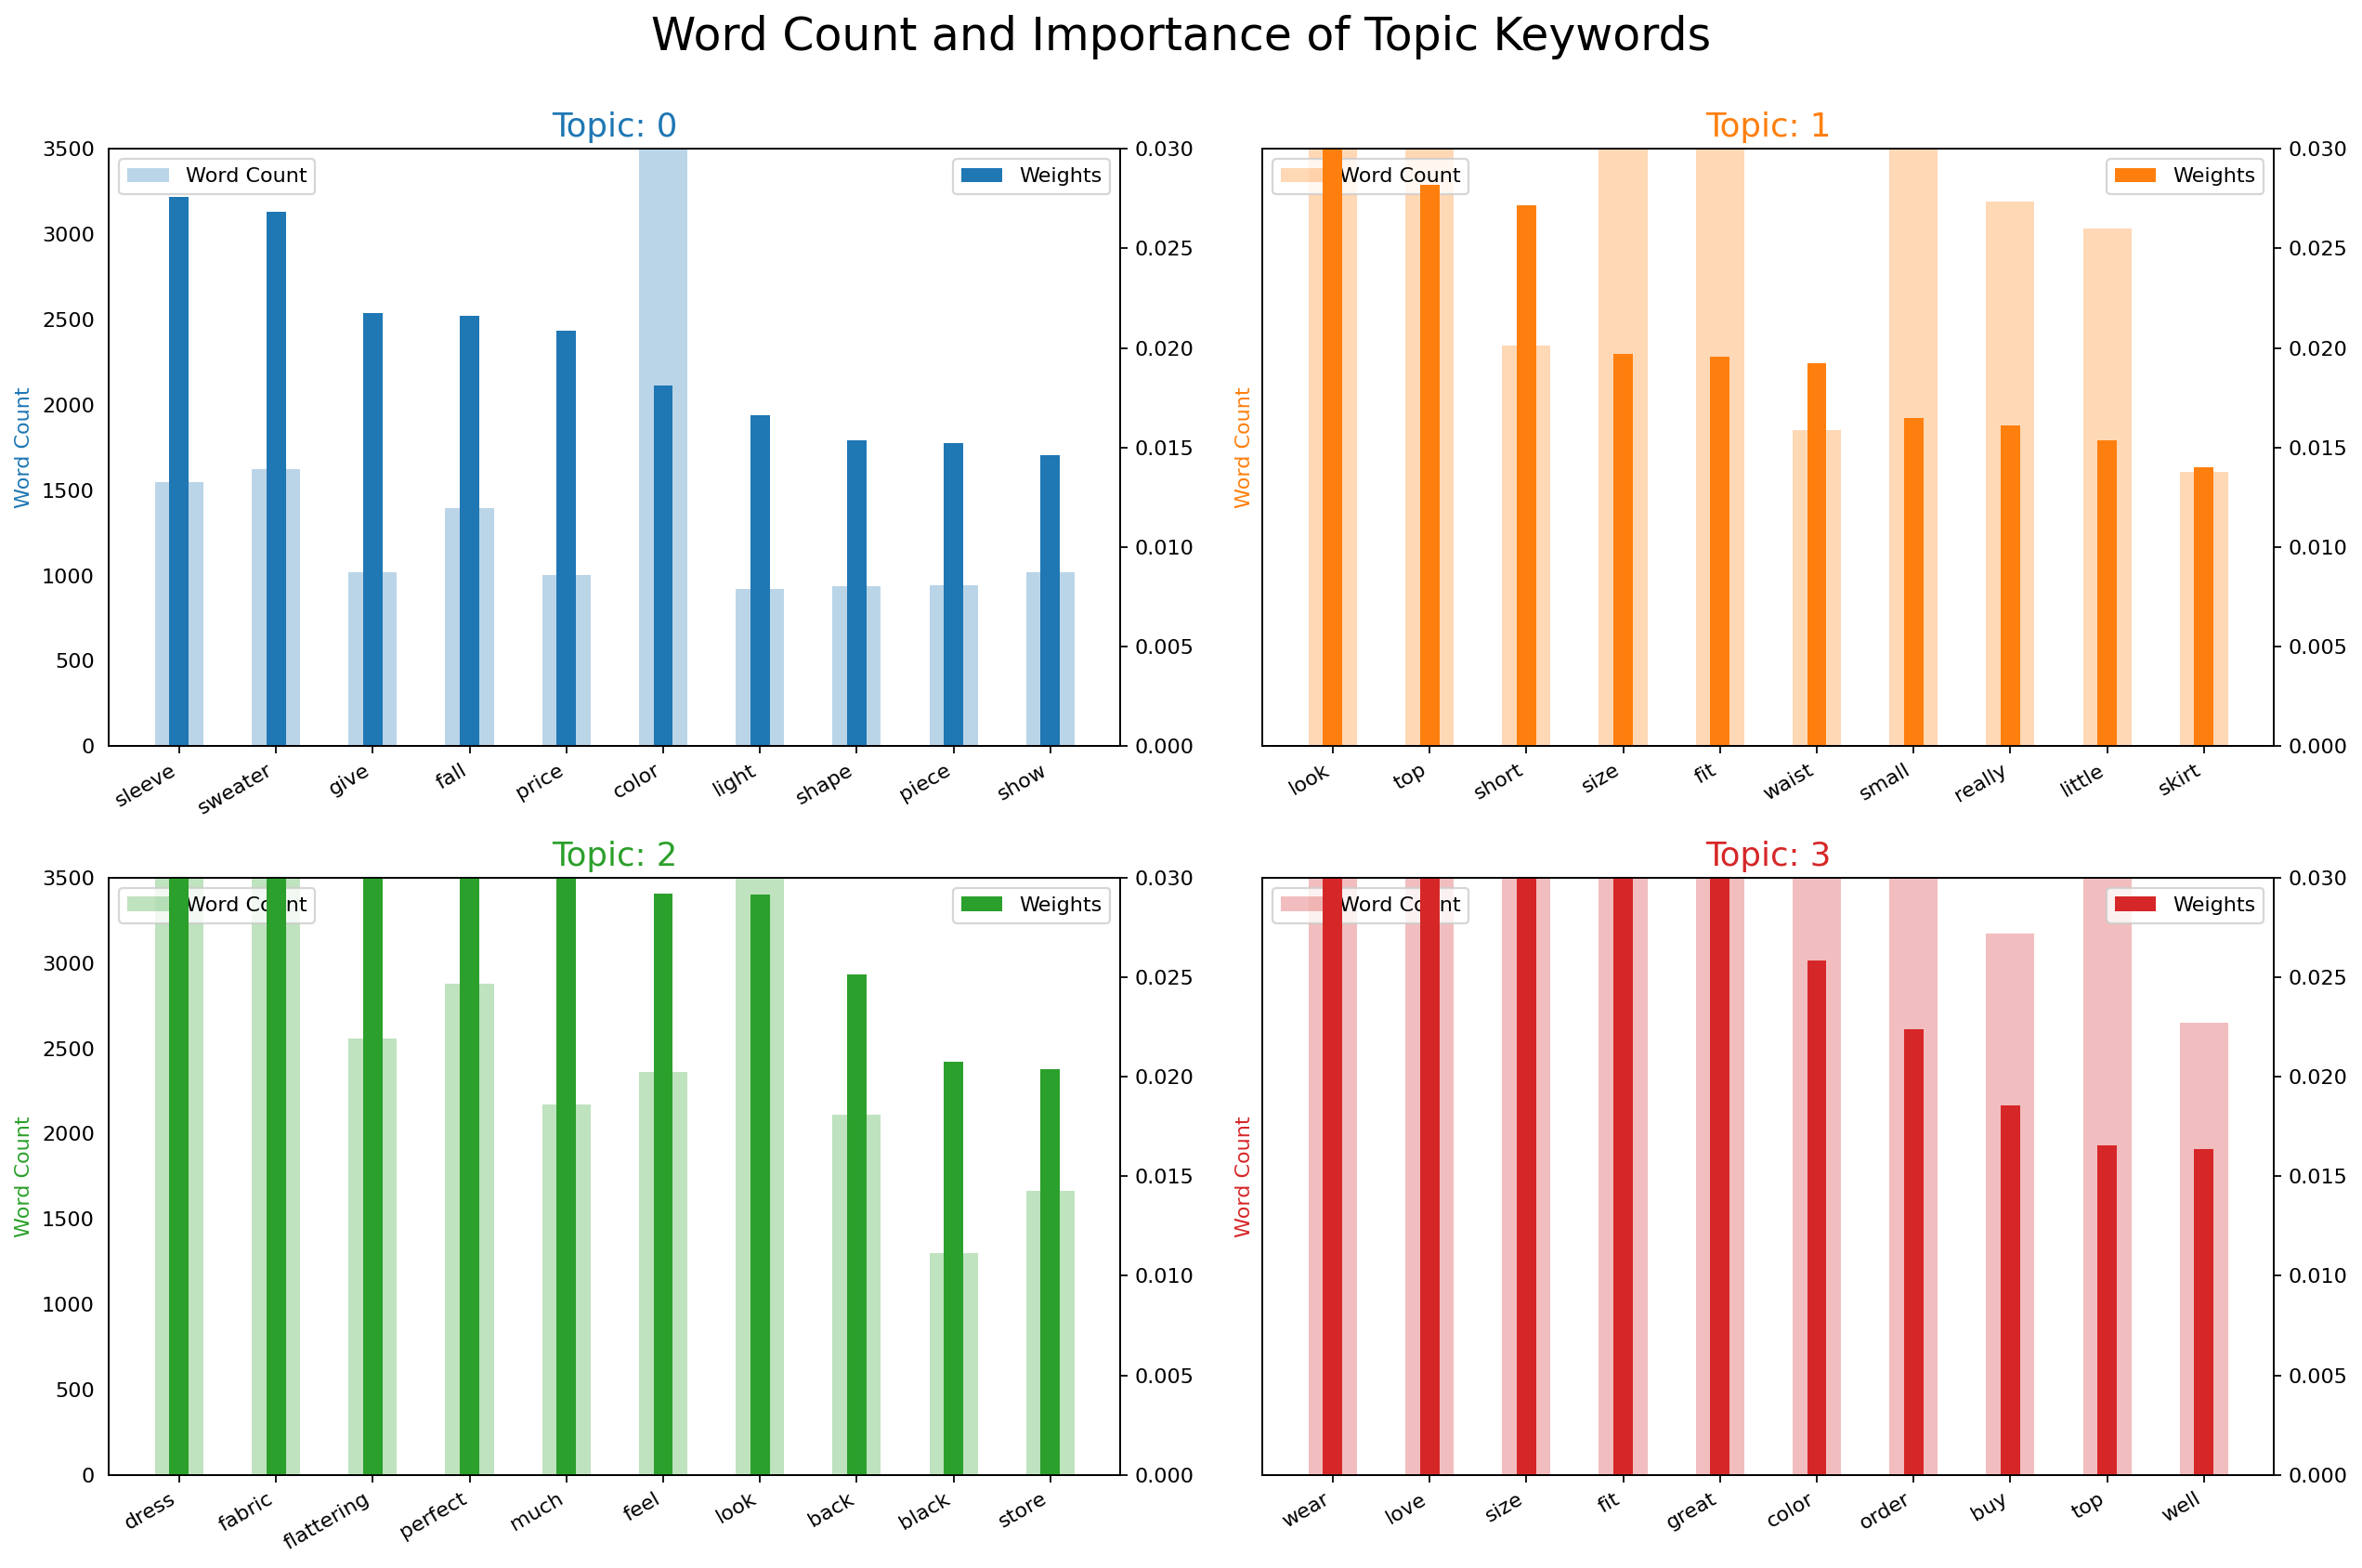

In [29]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

# t-SNE Clustering Chart

In [32]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 16289 samples in 0.010s...
[t-SNE] Computed neighbors for 16289 samples in 0.470s...
[t-SNE] Computed conditional probabilities for sample 1000 / 16289
[t-SNE] Computed conditional probabilities for sample 2000 / 16289
[t-SNE] Computed conditional probabilities for sample 3000 / 16289
[t-SNE] Computed conditional probabilities for sample 4000 / 16289
[t-SNE] Computed conditional probabilities for sample 5000 / 16289
[t-SNE] Computed conditional probabilities for sample 6000 / 16289
[t-SNE] Computed conditional probabilities for sample 7000 / 16289
[t-SNE] Computed conditional probabilities for sample 8000 / 16289
[t-SNE] Computed conditional probabilities for sample 9000 / 16289
[t-SNE] Computed conditional probabilities for sample 10000 / 16289
[t-SNE] Computed conditional probabilities for sample 11000 / 16289
[t-SNE] Computed conditional probabilities for sample 12000 / 16289
[t-SNE] Computed conditional probabilities for sam

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.741798
[t-SNE] KL divergence after 1000 iterations: 1.411164


# pyLDAVis (Most used)

In [38]:
# !pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
lda_viz = gensimvis.prepare(lda_model, corpus, lda_model.id2word)
lda_viz

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:302: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  token_table['Freq'] = token_table['Freq'].round()
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.184118  0.143192       1        1  38.994547
1     -0.247614 -0.024130       2        1  25.639043
2      0.134495 -0.342746       3        1  19.810714
0      0.297237  0.223683       4        1  15.555696, topic_info=           Term         Freq        Total Category  logprob  loglift
4         dress  8639.000000  8639.000000  Default  30.0000  30.0000
43         wear  7715.000000  7715.000000  Default  29.0000  29.0000
116      fabric  3276.000000  3276.000000  Default  28.0000  28.0000
117  flattering  3105.000000  3105.000000  Default  27.0000  27.0000
26        great  4664.000000  4664.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
20        color  1106.785388  5058.935779   Topic4  -4.0098   0.3410
75      quality   708.614710  1996.102374   Topic4  -4.4557   0.8251
74       pretty   572.848372  1667.683039   Topic4  -4.6684   0.7922
80         well   626.958958  3134.328266   Topic4  -4.5781   0.2515
187        soft   499.248860  2702.357356   Topic4  -4.8059   0.1720

[201 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
234       3  0.997567  absolutely
235       2  0.998977         add
115       3  0.998309    adorable
647       3  0.998164     amazing
135       2  0.998339        area
...     ...       ...         ...
794       1  0.998266       white
152       2  0.998735        wide
196       4  0.997632      winter
45        1  0.543814        work
45        2  0.455872        work

[187 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 1])